In [2]:
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
''')

/Users/jeffreyshragge/miniconda3/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


![title](data/TITLE.png)

### <h1><center>Module 5: 1D Fourier Transforms</center></h1>

Let's begin our discussion of Fourier Transforms by looking at a few interesting signals.  The example below shows four different musical instruments all playing the same note - middle C (or 523 Hz).

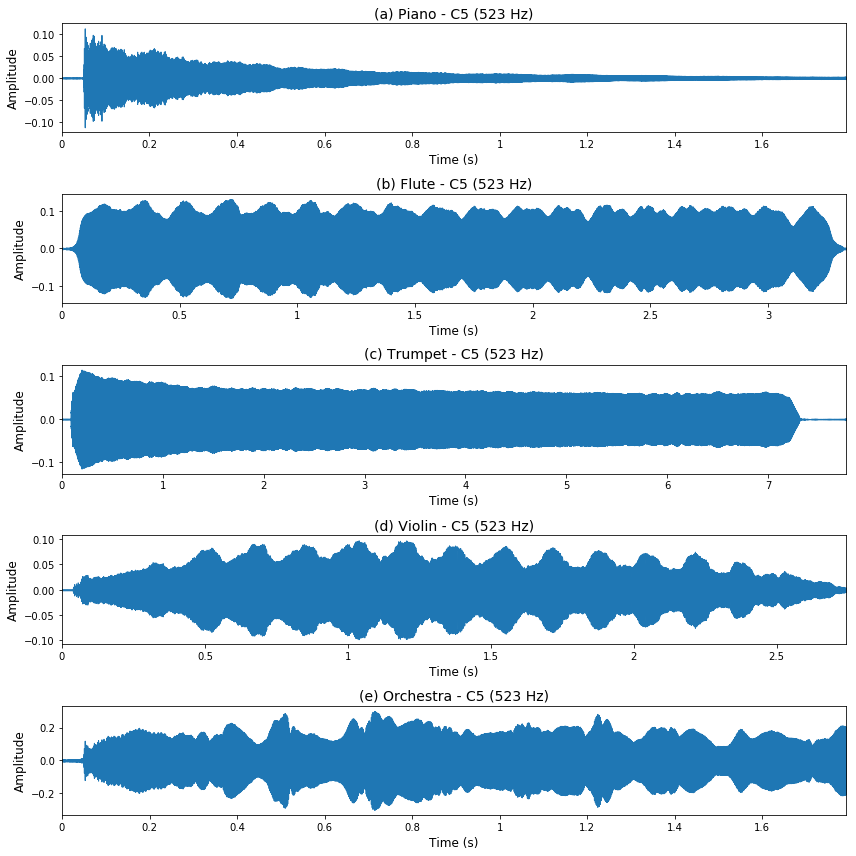

In [2]:
def plot_instrument(f, srp, title):
    librosa.display.waveplot(f, sr=srp)
    plt.xlabel('Time (s)',fontsize=12)
    plt.ylabel('Amplitude',fontsize=12)
    plt.title(title,fontsize=14)

## . . Let's load in some other wave files related to musci
piano  , srp = librosa.load('wav/piano-C5.wav')
flute  , srf = librosa.load('wav/flute-C5.wav')
trumpet, srt = librosa.load('wav/trumpet-C5.wav')
violin , srv = librosa.load('wav/violin-C5.wav')

## . . Subtract off mean value of each signal(i.e., remove DC component)
## . . Think about what '=' means in this context!
piano   = piano  -np.mean(piano  );
flute   = flute  -np.mean(flute  );
trumpet = trumpet-np.mean(trumpet);
violin  = violin -np.mean(violin );

## . . Let's combine them!
## . . Not all of the files are of the same size ... so can only combine to the minimum file size
minsize = min([piano.size,flute.size,trumpet.size,violin.size]) 
## . . Think about what the command above is doing!
#print('minimum file size is: ',minsize)

## . . You notice that the trumpet wav file has a lot silence at the beginning.  
## . . Let's start this 'tstart' samples in
tstart=19000

## . . Take a stab at superposing the different instruments
## . . For code readability we can use the line continuation operator '\'!
## . . We have defined the object class of 'orchestra'... it inherits it from the context
orchestra = 2.*piano[1:minsize]+ \
               flute[1:minsize]+ \
               trumpet[tstart+1:minsize+tstart]+ \
               violin[1:minsize]
## . . Note that you are 'slicing' the array!

## . . Let's plot the different instruments
plt.figure(figsize=(12, 12))

## . . Create a multiplot figure with 5 vertical panels
## . . (Five horizontal panels would be plt.subplot(151) ) 
plt.subplot(511)
plot_instrument(2*piano,srp,'(a) Piano - C5 (523 Hz)')

plt.subplot(512)
plot_instrument(flute,srf,'(b) Flute - C5 (523 Hz)')

plt.subplot(513)
## . . Notice the interesting way you are'slicing' for the trumpet array!
plot_instrument(trumpet[tstart:],srt,'(c) Trumpet - C5 (523 Hz)')

plt.subplot(514)
plot_instrument(violin,srv,'(d) Violin - C5 (523 Hz)')

plt.subplot(515)
plot_instrument(orchestra,srv,'(e) Orchestra - C5 (523 Hz)')

plt.tight_layout() # . . Make it so that the subplots don't overlap
plt.show()

**Figure 1. Illustration of different instruments playing middle C (i.e., C5 at 523 Hz). (a) Piano. (b) Flute. (c) Trumpet. (d) Violin. (e) Orchestra representing the superposition of (a)-(d).**

Let's now look at and listen to them individually ...

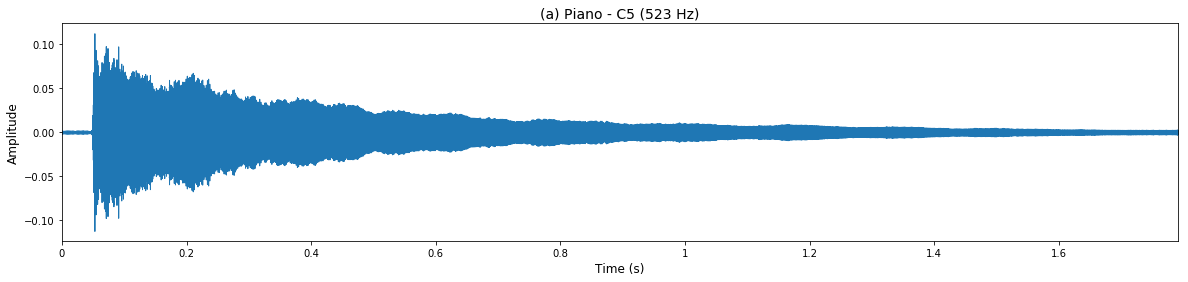

In [3]:
plt.figure(figsize=(20, 4)) 
plot_instrument(2*piano,srp,'(a) Piano - C5 (523 Hz)')
plt.show()

**Figure 2. Illustration of a piano recorded playing middle C at 523 Hz.**

Let's now listen to this waveform:

In [4]:
ipd.Audio(piano, rate=srp) # load a NumPy array

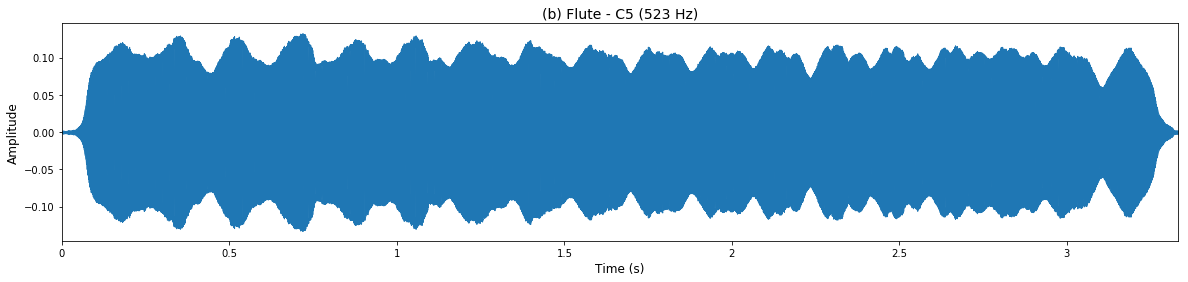

In [5]:
plt.figure(figsize=(20, 4))
plot_instrument(flute,srf,'(b) Flute - C5 (523 Hz)')
plt.show()

**Figure 3. Illustration of a flute recorded playing middle C at 523 Hz.**

Let's now listen to this waveform:

In [6]:
ipd.Audio(flute, rate=srp) # load a NumPy array

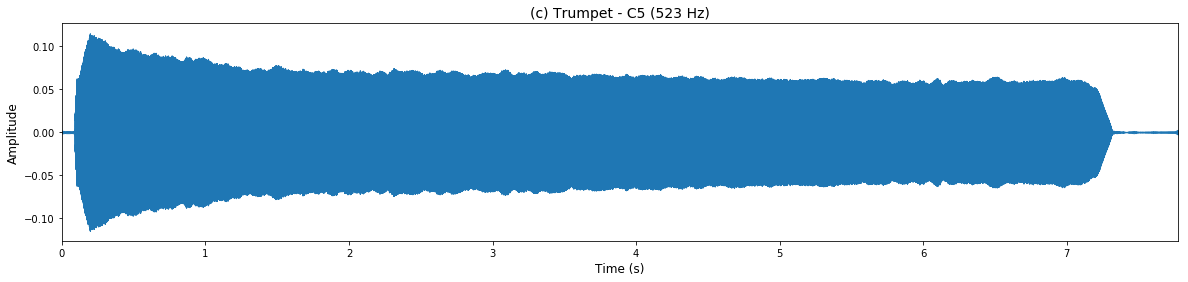

In [7]:
plt.figure(figsize=(20, 4))
plot_instrument(trumpet[tstart:],srt,'(c) Trumpet - C5 (523 Hz)')
plt.show()

**Figure 4. Illustration of a trumpet recorded playing middle C at 523 Hz.**

Let's now listen to this waveform:

In [8]:
ipd.Audio(trumpet, rate=srp) # load a NumPy array

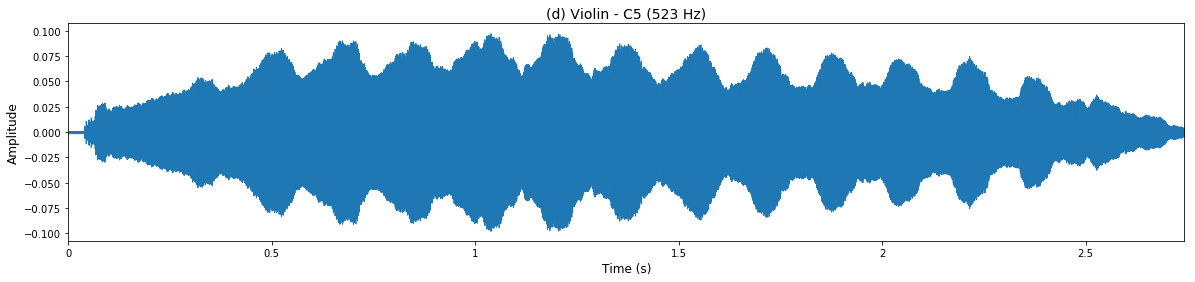

In [9]:
plt.figure(figsize=(20, 4))
plot_instrument(violin,srv,'(d) Violin - C5 (523 Hz)')
plt.show()

**Figure 5. Illustration of a violin recorded playing middle C at 523 Hz.**

Let's now listen to this waveform:

In [10]:
ipd.Audio(violin, rate=srp)

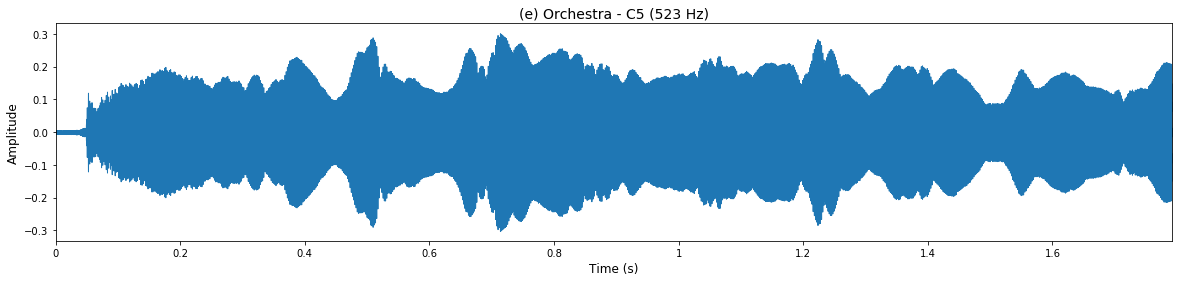

In [11]:
plt.figure(figsize=(20, 4))
plot_instrument(orchestra,srv,'(e) Orchestra - C5 (523 Hz)')
plt.show()

**Figure 6. Illustration of an "orchestra" recorded playing middle C at 523 Hz.**

Let's now listen to this waveform:

In [12]:
## . . Let's hear the contriving orchestra sound
ipd.Audio(orchestra, rate=srp) 

Let's now look at a very different type of signal: an earthquake.  Here's an example of a vertical component of an earthquake recording:

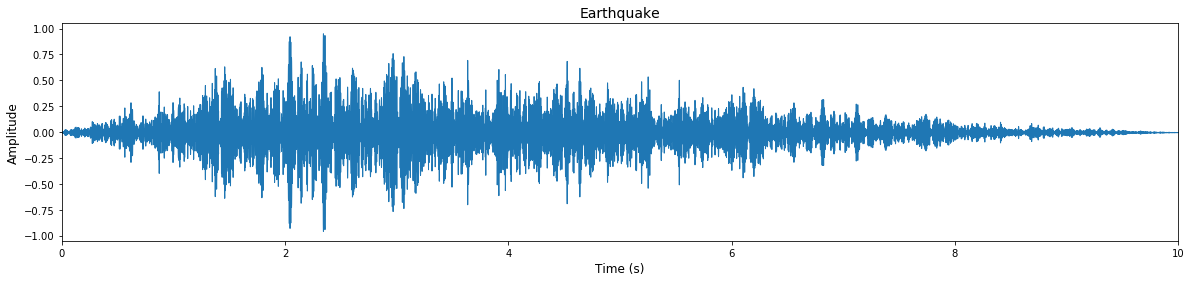

In [13]:
## . . Let's load in a vertical component of an earthquake recording
equake, sr = librosa.load('wav/equake4.wav')
plt.figure(figsize=(20, 4))
plot_instrument(equake,sr,'Earthquake')
plt.show()

**Figure 7. Vertical component of a recorded distant earthquake signal (normalized).**

Let's now listen to the earthquake:

In [14]:
ipd.Audio(equake, rate=sr) # load a NumPy array

You'll obviously have heard that the earthquake sounds quite different than the musical intruments.  Why is this? How can we describe this mathematically? Why can't we use Fourier Series? Because this is an **aperiodic** signal, we must use a different tool: the **Fourier Transform**.

# Fourier Transforms - The Basics

## Fourier Transform 

[Fourier Transforms](https://en.wikipedia.org/wiki/Fourier_transform) (or FTs) are used to decompose a **continuous-time aperiodic** signals into its constituent frequencies. (The pair of time $t$ and angular frequency $\omega$ are termed [conjugate variables](https://en.wikipedia.org/wiki/Conjugate_variables).) For example, think about decomposing a recorded piece of music into its individual notes (aka frequencies!) that make up the composition.  The magnitude of the FT then corresponds to magnitude of that frequency present in the composition.  The phase of the FT describes the offset of that frequency from the basic sinusoid.  Note that unlike the Fourier Series, FTs are defined on a continuous range of frequencies $\omega$.

The Fourier Transform (commonly denoted $\mathcal{F}$) of an **aperiodic** and **continuous time** signal $x(t)$ is given by:

<div class="alert alert-info">
$$
\widehat{X}(\omega) = \int_{-\infty}^{\infty} x(t)\,\mathrm{e}^{-i\omega t} \mathrm{d}t = \mathcal{F}[x(t)], \tag{1}
$$
</div>

where $\widehat{X}(\omega)$ is also called the Fourier representation of $x(t)$ in the frequency domain.  In this course I will denote functions in the conjugate Fourier domain by the $\LaTeX$ *wide-hat* symbol - e.g., $\widehat{\gamma}$. In general, $\widehat{X}(\omega)$ is a complex-valued function.

## Inverse Fourier Transform

The [inverse Fourier Transform](https://en.wikipedia.org/wiki/Fourier_inversion_theorem) (commonly denoted $\mathcal{F}^{-1}$) is given by:

<div class="alert alert-info">
$$
x(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} \widehat{X}(\omega) \, \mathrm{e}^{i \omega t} \,\mathrm{d}\omega = \mathcal{F}^{-1}[\widehat{X}(\omega)]. \tag{2}
$$
</div>

Note that $\mathcal{F}^{-1}$ is defined this way such that the following holds:

$$
\begin{eqnarray}
\mathcal{F}^{-1} \left( \mathcal{F} g(t) \right) & = & g(t) \\
\mathcal{F} \left( \mathcal{F}^{-1} \widehat{G}(\omega) \right) &=& \widehat{G}(\omega). \\
\end{eqnarray}  \tag{3}
$$

Also, note the following 

$$ F^0 = \mathrm{Iden}, \quad F^{1} = \mathcal{F}, \quad F^{2} = \mathcal{P}, \quad F^{3}=\mathcal{F}^{-1}, \quad F^{4} = \mathrm{Iden},  \tag{4}
$$

where $\mathcal{P}$ is the **Parity operator** that inverts time: $\mathcal{P[f(t)]}\rightarrow f(-t)$.  Over your science and engineering careers you will no doubt grow to appreciate the invertibility of a wide number of transformations!


## Fourier Power Spectrum

You might often hear the term [Fourier Power Spectrum](https://en.wikipedia.org/wiki/Spectral_density) or something meant to be equivalent (e.g., energy spectral density or power spectral density).  When you hear this people are generally talking about the **power spectrum**, which is given by:

$$ \left|\widehat{X}(\omega) \right|^2 = \widehat{X}(\omega)\overline{ \widehat{X}(\omega)}. \tag{5} $$

### Alternate conventions for the Fourier Transform

Note that, like the Fourier Series, there are alternate definitions of the Fourier Transform than that specified above. In particular, note the following:

$$ \widehat{F}(f) = \int_{-\infty}^{\infty} f(t)\,e^{-i2\pi f t} \mathrm{d}t \tag{6}$$

and

$$ f(t) = \int_{-\infty}^{\infty} \widehat{F}(f)\,e^{i2\pi f t} \mathrm{d}f. $$

It is important to note that this alternate definition leads to different frequency-domain scaling than that discussed above.  Alternatively, one often sees a "symmetric version" of the Fourier Transform specified by angular frequency:


$$\widehat{X}(\omega) = \frac{1}{\sqrt{2\pi} }\int_{-\infty}^{\infty} x(t)\,\mathrm{e}^{-i\omega t} \mathrm{d}t  \tag{7}$$

and 

$$ x(t) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \widehat{X}(\omega) \, \mathrm{e}^{i \omega t} \,\mathrm{d}\omega.\tag{8} $$

Some people really like symmetry...

### Fourier Transform of a Beat Pattern

Let's look at an example where we have a function

$$f(t) = 2\cos (2\pi f_1 t) + 4\sin (2\pi f_2 t) \tag{9}$$

For the discussion below, take note that this function is a combination of even ($\cos$) and odd ($\sin$) terms.  

Let's first plot this for two nearby frequencies where $f_1=3.9$Hz and $f_2=4.1$Hz.

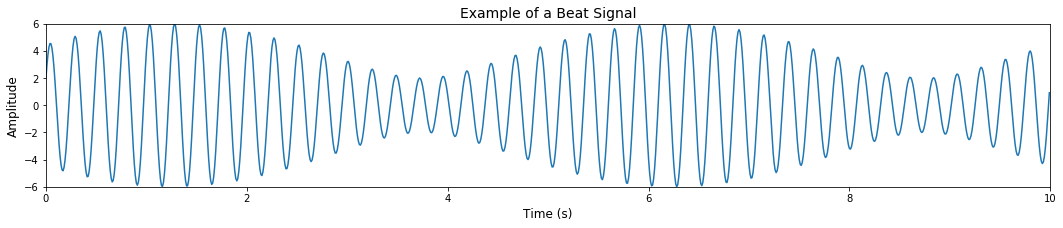

In [30]:
## . . Let's define a few key parameters
Fs = 100         # sampling rate
Ts = 1.0/Fs           # sampling interval
tmin,tmax=0.,10  # Start/stop times
f1,f2 =3.9,4.1        # the two frequencies

## . . let's define a time vector 
t = np.arange(tmin,tmax,Ts)
y = np.zeros((len(t)))

## . . Define two nearby frequencies to make a beat pattern
w1 = 2.0*np.pi*f1;   # angular frequency of signal component #1
w2 = 2.0*np.pi*f2;   # angular frequency of signal component #2

## . . make signal y(t)
y = 2.*np.cos(w1*t) + 4.*np.sin(w2*t)

## . . Let's plot y(t)
plt.figure(figsize=(18, 3))
plt.plot(t,y)
plt.xlabel('Time (s)',fontsize=12)
plt.ylabel('Amplitude',fontsize=12)
plt.title('Example of a Beat Signal',fontsize=14)
plt.axis([tmin,tmax,y.min(),y.max()])
plt.show()          

**Figure 8. Illustration of a beat pattern due to the superposition of two signals that are close in their frequency structure.  Here, I'm using $f_1=3.9$ Hz and $f_2=4.1$ Hz.**

Let's now listen to this superimposed signals:

In [31]:
ipd.Audio(y, rate=sr/5) 

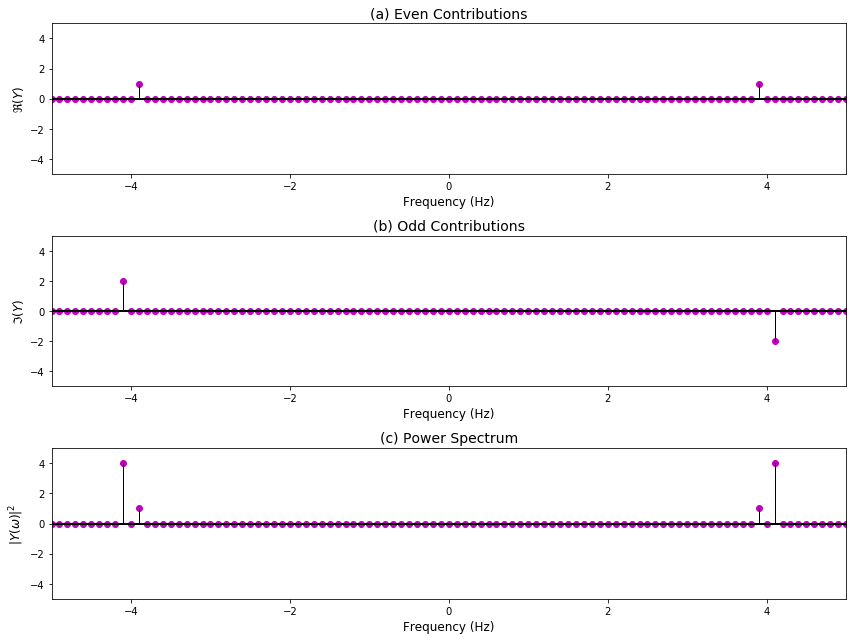

In [32]:
def stem_plot(f,g,Fs,ylabel,title):
    markerline, stemlines, baseline = plt.stem(f,g,'-.') # . . returns 3 objects 
    plt.setp(baseline, 'color', 'k', 'linewidth', 2) # . . Adjust the y=0 baseline
    plt.setp(stemlines, 'color', 'k', 'linewidth', 1,'linestyle','-') # . . Adjust stem lines black (k) and solid (-)
    plt.setp(markerline, 'color', 'm')# . . Adjust marker dots to be magenta (m)
    plt.xlabel('Frequency (Hz)',fontsize=12)
    plt.ylabel(ylabel,fontsize=12)
    plt.title(title,fontsize=14)
    plt.axis([-Fs/6,Fs/6,-5,5])
    
## . . length of the signal
## . . Note: y is the signal defined above
n = len(y)

## . . Define the Fourier vector
freqs = np.fft.fftfreq(n,Ts)

## . . Compute the numerical Fourier Transform
## . . More about this later in the course!
Y = np.fft.fft(y)/n     # fft computing and normalization by signal length

# . . Make a figure with three subpanels
plt.figure(figsize=(12, 9))

# . . Plot the real component of the Fourier Transform
plt.subplot(311)
stem_plot(freqs,np.real(Y),Fs,'$\Re(Y)$','(a) Even Contributions')
plt.xlim(-5,5)

# . . Plot the imaginary component of the Fouri/er Transform
plt.subplot(312)
stem_plot(freqs,np.imag(Y),Fs,'$\Im(Y)$','(b) Odd Contributions')
plt.xlim(-5,5)

# . . Plot the PSD of the Fourier Transform
plt.subplot(313)
stem_plot(freqs,np.real(Y*np.conj(Y)),Fs,'$|Y(\omega)|^2$','(c) Power Spectrum')
plt.xlim(-5,5)

plt.tight_layout() # . . Make it so that the subplots don't overlap
plt.show()      

**Figure 9.  Illustration of different Fourier components of the beat signal $y(t)=2\cos 2\pi 3.9t + 4\sin 2\pi 4.1t$ from Figure 8.  The (a) real and (b) imaginary components of the Fourier spectrum. (c) The power spectrum.  Note that the even and odd contributions are at half the amplitude of the time-domain signal, while the power spectrum is the square of half the amplitude. This is because the amplitudes are split into positive and negative frequencies as per Euler's formula.**

### A note about frequency structure of the np.fft.fft()

One of the interesting things to get your head around is the layout of the frequency axis.  Let's first plot the *freqs* function from the above example.

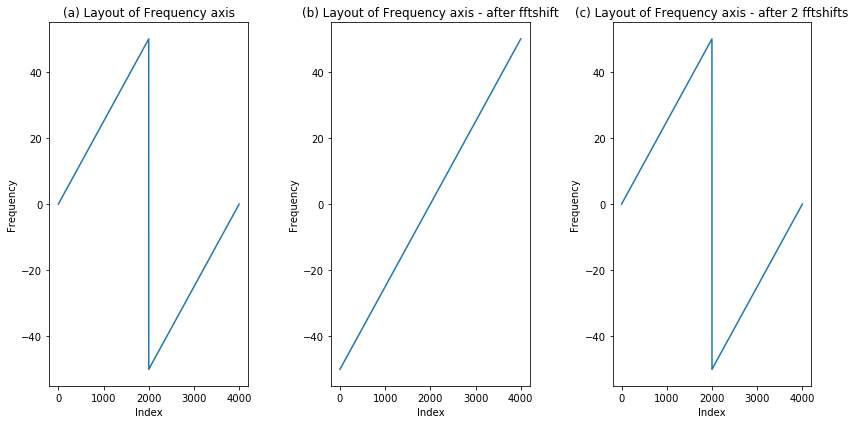

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.plot(freqs)
plt.ylabel('Frequency')
plt.xlabel('Index')
plt.title('(a) Layout of Frequency axis')

plt.subplot(132)
plt.plot(np.fft.fftshift(freqs))
plt.ylabel('Frequency')
plt.xlabel('Index')
plt.title('(b) Layout of Frequency axis - after fftshift')

plt.subplot(133)
plt.plot(np.fft.fftshift((np.fft.fftshift(freqs))))
plt.ylabel('Frequency')
plt.xlabel('Index')
plt.title('(c) Layout of Frequency axis - after 2 fftshifts')

plt.tight_layout() 
plt.show()

**Figure 10. Illustrating the layout of the frequency structure in the Fourier Transfom. (a) The actual layout of the frequencies. (b) Layout of the frequency axis after using the *np.fft.fftshift()* command. (c) The frequency layout after twice applying *np.fft.fftshift()*, which returns the frequencies back to the original layout.**

In the first subplot we see that the frequency layout isn't as one might expect. It actually goes from $[0,f_{max}]$ and then from $[-f_{max},0]$.  To get these plotted in the regular layout from $[-f_{max},f_{max}]$ we have to use the *np.fft.fftshift()* command.  This is illustrated in panel (b).  If we apply the *np.fft.fftshift()* command again, the we can reconstruct the original time series.

The reason why we need this is that the output of *np.fft.fft()* has the order $[0,f_{max}]$ and then from $[-f_{max},0]$.  Thus, to plot a Fourier transform in the expected order you must do something like:

* *plt.plot(np.fft.fftshift(freqs),np.fft.fftshift(My_FT_signal))*

Note that the *np.fft.fftshift()* command can take 1D, 2D ... ND data!


## The Dirichlet Conditions

In the above examples we have taken the Fourier transform without really think about whether we can apply this transformation. This observation raises the following question: **can all functions be Fourier transformed?**
The short answer is no. Functions $f(t)$ and $\widehat{F}(\omega)$ must obey a number of conditions that are termed the **Dirichlet Conditions**. These are that a function must be:


(1) Square integrable; i.e., $\int_{-\infty}^{\infty} |f(t)| \, \mathrm{d}t$ is finite, which implies that $f(t)\rightarrow 0$ as $|t|\rightarrow \infty$
   * What is the consequence of a function not being square integrable?
    
    
(2) Single valued
   * What is the consequence of a function not being single valued?
    
    
(3) Be piecewise continuous within the specified interval
   * Step, boxcar and absolute values functions are permitted 


(4) Have upper and lower bounds

Note that the $\delta$-function does not obey these conditions; however, the ''legitimacy'' of this function can be established by advanced Fourier Analysis.

# Examples of Fourier Transforms (Part 1)

Let's now examine a number of canonical Fourier transforms that will be very useful for this course.

### Example 1a - Box Car (time domain)

**Q:** Find the Fourier Transform of $x(t)$, which is a box-car pulse $\Pi_{T_0}$ of the form:

$$
x(t) = \Pi_{T_0}(t)
=
\left\{
\begin{array}{ll}
1, & -T_0<t<T_0\\
0, & \mathrm{otherwise}
\end{array}
\right.  \tag{10}
$$

**A:** Note that the signal is of finite length and corresponds to one period of the box-car example examined in the Fourier Series notebook.

$$
\begin{eqnarray}
\widehat{X}(\omega) = \int_{-\infty}^{\infty} x(t)\,\mathrm{e}^{-i\omega t}\,\mathrm{d}t \tag{11a} \\
= \int_{-T_0}^{T_0} \mathrm{e}^{-i\omega t}\,\mathrm{d}t \tag{11b}\\
= \left.\frac{\mathrm{e}^{-i\omega t}}{-i\omega}\right|_{-T_0}^{T_0} \tag{11c} \\
= \frac{\mathrm{e}^{-i\omega T_0}-\mathrm{e}^{i\omega T_0}}{-i\omega} \tag{11d}\\
= \frac{\mathrm{e}^{i\omega T_0}-\mathrm{e}^{-i\omega T_0}}{i\omega} \tag{11e}\\
= \frac{2\mathrm{sin}(\omega T_0)}{\omega} \tag{11f}\\
= \frac{2T_0\mathrm{sin}(\omega T_0)}{\omega T_0} \tag{11g} \\
= 2T_0 \mathrm{sinc} (\omega T_0) \tag{11h}
\end{eqnarray}
$$

where in the last step we have used the definition of ${\rm sinc}$ function (i.e., $\frac{\sin ax}{ax} = {\rm sinc}\,ax$). Note that for $T_0=1/2$, and in this case $\omega=2\pi/T_0$, we obtain:

$$ \frac{2\mathrm{sin}(\omega T_0)}{\omega} = \frac{\mathrm{sin}(\pi f)}{\pi f} = \mathrm{sinc} \,\pi f, \tag{12}$$

which is the important **sinc** function.

### Example 1b - Box Car (frequency domain)

**Q:** Find the inverse Fourier transform of $\widehat{X}(\omega)$ which is a rectangular box-car pulse $\widehat{\Pi}(\omega)$ of the form:

$$
\widehat{X}(\omega) = 
\widehat{\Pi}(\omega)
=\left\{
\begin{array}{ll}
1, & -\omega_0<\omega<\omega_0\\
0, & \mathrm{otherwise}
\end{array}
\right. \tag{13}
$$

**A:** From above we get:

$$
\begin{eqnarray}
x(t) = \frac{1}{2\pi}\int_{-\infty}^{\infty}\widehat{X}(\omega)\,\mathrm{e}^{i\omega t}\, \mathrm{d}\omega \tag{14a} \\
= \frac{1}{2\pi}\int_{-\omega_0}^{\omega_0} \mathrm{e}^{i\omega t}\,\mathrm{d}\omega \tag{14b}\\
= \left.\frac{\mathrm{e}^{i\omega t}}{i2\pi t} \right|_{-\omega_0}^{\omega_0} \tag{14c}\\
= \frac{\mathrm{e}^{i\omega_0 t} - \mathrm{e}^{-i\omega_0 t}}{i2\pi t} \tag{14d}\\
= \frac{\mathrm{sin}(\omega_0 t)}{\pi t}  \tag{14e}\\ 
= \frac{2\omega_0}{2\pi}\,\mathrm{sinc}\left(\omega_0 t\right) \tag{14f}
\end{eqnarray}
$$

Note that these two demonstrate the **duality property** of the Fourier Transform: The (inverse) Fourier transform of a boxcar function is a (scaled) sinc function! The only difference are the normalization factor of $\frac{1}{2\pi}$ and that the time domain has a $T_0$ while the Fourier domain has $\omega_0$.

# Properties of the Fourier Transform

There are a number of key properties of the Fourier transform that are well worth knowing.  Assume that $f(t)$, $g(t)$ and $h(t)$ are **integrable functions** obeying, 

$$ \int_{-\infty}^{\infty} \left|f(t)\right| \mathrm{d}t \lt \infty \tag{15} $$

and have Fourier transforms $\widehat{F}(\omega)$, $\widehat{G}(\omega)$ and $\widehat{H}(\omega)$, respectively.  Given these requirements, the following are six key properties: Linearity, Translation, Modulation, Time scaling, Conjugation and Integration.

## Linearity

For any complex numbers $a$ and $b$, if $h(t)=a f(t)+b g(t)$ then

$$ \widehat{H}(\omega) = a \widehat{F}(\omega)+ b \widehat{G}(\omega). \tag{16} $$

## Translation / time shifting

For any real number $t_0$, if $h(t)=f(t-t_0)$ then 


$$ \widehat{H}(\omega)  = \mathrm{e}^{-i \omega t_0 }\,\widehat{F}(\omega) \tag{17} $$

## Modulation / frequency shifting

For any real number $\omega_0$ if $h(t) = \mathrm{e}^{i\omega_0t} f(t)$ then

$$  \widehat{H}(\omega) = \widehat{F}(\omega-\omega_0) \tag{18}. $$

## Time Scaling (and Time Reversal)

For any non-zero real constant $a$, if $h(t) = f(at)$ then

$$ \widehat{H}(\omega) = \frac{1}{|a|}\widehat{F}(\omega/a) \tag{19}. $$

One key thing to remember is that when the time is dilated (i.e., $|a|>1$) then the frequency range in compressed $\omega/|a|$ (and vice versa).  Note that the case $a=-1$ leads to the **time-reversal** property, which states if $h(t)=f(-t)$ then $\widehat{H}(\omega) = \widehat{F}(-\omega)$.

## Conjugation

If $h(t)=\overline{f(t)}$ then,

$$\widehat{H}(\omega) = \overline{\widehat{F}(-\omega)}. \tag{20}$$

Note that if $f(t)$ is real then $\widehat{F}(-\omega)=\overline{\hat{F}(\omega)}$.  Similarly, if it is purely imaginary then $\widehat{F}(-\omega)=-\overline{\widehat{F}(\omega)}$.

## Integration

Substituting $\omega=0$ in the definition, we obtain

$$ \widehat{F}(0)=\int_{-\infty}^{\infty} f(t) \,\mathrm{d}t, \tag{21} $$

which is equivalent to recovering the [DC Component](https://en.wikipedia.org/wiki/DC_bias) of the Fourier spectrum.

## Proofs of Fourier Properties

Prove the following the Fourier Transform properties.

**(1) Time Translation**

<div class="alert alert-success">
Show if $h(t)=f(t-t_0)$ then $\widehat{H}(\omega) = e^{-i\omega t_0}\widehat{F}(\omega)$
   
   $$
   \begin{eqnarray}
   \widehat{H}(\omega) &=& \int_{-\infty}^{\infty} f(t-t_0) e^{-i\omega t} \mathrm{d}t \tag{22a} \\
                        &=& \int_{-\infty}^{\infty} f(t-t_0) e^{-i\omega t} e^{-i\omega t_0} e^{i\omega t_0} \mathrm{d}t \tag{22b}\\
                        &=& \int_{-\infty}^{\infty} f(t-t_0) e^{-i\omega (t-t_0)} e^{-i\omega t_0} \mathrm{d}t \tag{22c}\\                        
   \end{eqnarray}
   $$

Now, since (1) $t_0$ is a constant, $\mathrm{d}(t-t_0)=\mathrm{d}t$; and (2) $e^{-i\omega t_0}$ is independent of $t$, we can write:

   $$
   \begin{eqnarray}
\widehat{H}(\omega)&=& e^{-i\omega t_0}\int_{-\infty}^{\infty} f(t-t_0) e^{-i\omega (t-t_0)} \mathrm{d}(t-t_0) \tag{23} \\
   \end{eqnarray}
   $$

Defining $t^\prime=t-t_0$, we write:

   $$
   \begin{eqnarray}
\widehat{H}(\omega)&=& e^{-i\omega t_0}\int_{-\infty}^{\infty} f(t^\prime) e^{-i\omega t^\prime} \mathrm{d}t^\prime \tag{24a}\\
&=& e^{-i\omega t_0} \widehat{F}(\omega) \tag{24b}\\
\end{eqnarray}
   $$

</div>

**(2) Frequency Modulation**

<div class="alert alert-success">
  Show if $h(t) = \mathrm{e}^{i\omega_0t} f(t)$ then $\widehat{H}(\omega) = \widehat{F}(\omega-\omega_0)$
  
   $$
   \begin{eqnarray}
\widehat{H}(\omega)&=& \int_{-\infty}^{\infty} f(t) e^{i\omega_0 t} e^{-i\omega t} \mathrm{d}t \tag{25a}\\
&=& \int_{-\infty}^{\infty} f(t)  e^{-i(\omega-\omega_0) t} \mathrm{d}t \tag{25b}\\
\end{eqnarray}
   $$  

Let $\omega^\prime = \omega-\omega_0$. Then we can write:

   $$
   \begin{eqnarray}
\widehat{H}(\omega) &=& \int_{-\infty}^{\infty} f(t)  e^{-i\omega^\prime t} \mathrm{d}t \tag{26a}\\
&=& \widehat{F}(\omega^\prime) \tag{26b}\\
&=& \widehat{F}(\omega-\omega_0) \tag{26c} 
\end{eqnarray}
   $$  
</div>

**(3) Time scaling**

<div class="alert alert-success">
   If $h(t) = f(at)$ (for real and constant $a \gt 0$) then $ \widehat{H}(\omega) = \frac{1}{a}\widehat{F}(\omega/a)$

   $$
   \begin{eqnarray}
\widehat{H}(\omega)&=& \int_{-\infty}^{\infty} f(at) e^{-i\omega t} \mathrm{d}t \tag{27} \\
\end{eqnarray}
   $$  
   
Define $t^\prime=at$ such that $t=t^\prime/a$ and $\mathrm{d}t = \mathrm{d}t^\prime/a$. Then,

   $$
   \begin{eqnarray}
\widehat{H}(\omega)&=& \int_{-\infty}^{\infty} f(t^\prime) e^{-i\omega t^\prime/a} \mathrm{d}t^\prime/a \tag{28}\\
\end{eqnarray}
   $$  
   
Defining $\omega^\prime = \omega/a$ and moving constant $a$ outside integral:

   $$
   \begin{eqnarray}
\widehat{H}(\omega)&=& \frac{1}{a} \int_{-\infty}^{\infty} f(t^\prime) e^{-i\omega^\prime t^\prime} \mathrm{d}t^\prime \tag{29a}\\
&=& \frac{1}{a} \widehat{F}(\omega^\prime) = \frac{1}{a} \widehat{F}(\omega/a) \tag{29b}
\end{eqnarray}
   $$  

Note that one can do this for $a < 0$ to establish the absolute values in equation 19 above.
</div>

# Examples of Fourier Transforms (Part 2)


There are several key functions that keep appearing through this course (and many others in geophysics!): Dirac delta function, Gaussian, Exponential Decay and the Dirac Comb (also known as the Pulse train or Shah Function).  It is very helpful to remember what the relationship between these functions are in the conjugate domains (e.g., $t$ and $\omega$).

## Dirac delta function - $\delta(t)$

The Dirac delta function, $\delta(t)$, has the following characteristics:

$$ \delta(t) = 0 \quad \mathrm{for} \quad t\neq 0  \tag{30} $$

and 

$$ \int_{-\infty}^{\infty}\delta(t) \, \mathrm{d}t  =  1.  \tag{31} $$

Interestingly, we are not defining the value of $\delta(t)$ at $t=0$. Rather we are defining it in terms of an integral.  Note also that this holds true for any delta function defined at $t=a$.  For example,

$$ \int_{-\infty}^{\infty}\delta(t-a) \, \mathrm{d}t  =  1  \tag{32} $$

The other key property studied here is:

$$ f(t)\,\delta(t-t_0)  =  f(t_0)\,\delta(t-t_0),  \tag{33} $$

where $f(t)$ is a continuous-time signal.  Equations 30 and 31 indicate that $\delta(t)$ has a very large value or *impulse* at $t=0$.  That is, $\delta(t)$ is not really defined at $t=0$. (Let's leave this alone for the moment.)  Equation 33 is known as the **sifting property** because it "sifts" through all possible answer and only "selects" the one that exactly makes the argument go to zero.

Thus, we could write the following Fourier Transform of $\delta(t)$:

$$ \mathcal{F}[\delta(t)] = \int_{-\infty}^{\infty}\delta(t) \, e^{-i\omega t} \mathrm{d}t = \int_{-\infty}^{\infty}\delta(t) \, e^{-i\omega 0} \mathrm{d}t = \int_{-\infty}^{\infty}\delta(t) \mathrm{d}t = 1.  \tag{34} $$


By use of the shift and scaling theorems, one can show that the following functions are Fourier pairs:

$$
\begin{eqnarray}
\delta (t-a) &\Leftrightarrow & \mathrm{e}^{-i\omega a} \tag{35a}\\
\delta (mt-a)&\Leftrightarrow & \frac{1}{m}\mathrm{e}^{-i\omega a/m}\tag{35b}
\end{eqnarray}  
$$

The first one can be demonstrated by the following:

$$
\begin{eqnarray}
\mathcal{F}[\delta(t-a)]& =& \int_{-\infty}^{\infty} \delta (t-a) e^{-i\omega t} \mathrm{d}t \tag{36a} \\
& =& \int_{-\infty}^{\infty} \delta (t-a) e^{-i\omega a} \mathrm{d}t \tag{36b} \\
 &=& e^{-i\omega a} \int_{-\infty}^{\infty} \delta (t-a) \mathrm{d}t \tag{36c}\\
 &=& e^{-i\omega a}  \tag{36d}
\end{eqnarray}
$$

where we have invoked the sifting property to go from equation 36a to 36b, and have used the property in equation 32 to go from equation 36c to 36d.

The following pairs of $\delta$-functions are useful to remember:

$$ 
\begin{eqnarray}
\frac{ \delta(t+a) + \delta(t-a)}{2} &\Leftrightarrow& \mathrm{cos}\,(a\omega) \tag{37a}\\
\frac{ \delta(t+a) - \delta(t-a)}{2i} &\Leftrightarrow&\mathrm{sin}\,(a\omega) \tag{37b}\\
\mathrm{cos}\,(at) &\Leftrightarrow& \pi \left[\delta(\omega-a) + \delta(\omega+a)\right] \tag{37c} \\
 \mathrm{sin}\,(at) &\Leftrightarrow& \frac{\pi}{i} \left[\delta(\omega-a) - \delta(\omega+a)\right]  
 \tag{37d}
\end{eqnarray}
$$

# Symmetry properties of the Fourier Transform

The symmetry properties of the Fourier transformation are described in Table 1 below.
<center>
    
|Property | $x(t)=x_r(t)+ix_i(t)$  | $\hat{X}(\omega)=\hat{X}_r(\omega)+i\hat{X}_i (\omega)$ |
|:-:|:----------------------:|:--------------------------:|
| 1  | Real $x(t)=x_r(t)$           | Even $\hat{X}_r(\omega)$, Odd $\hat{X}_i(\omega)$ |
| 2  | Real and Even $x(-t)= x_r(t)$ |  Real and Even $\hat{X}_r(\omega)$ |
| 3  | Real and Odd  $x(-t)=-x_r(t)$ |  Imaginary and Odd $\hat{X}_i(\omega)$ |
| 4  | Imaginary $x(t)=x_i(t)$ | Odd $\hat{X}_r(\omega)$, Even $\hat{X}_i(\omega)$ |
| 5  | Imaginary and even $x(-t)=x_i(t)$ | Imaginary and Even $\hat{X}_i(\omega)$|
| 6  | Imaginary and Odd $x(-t) = - x_i(t)$ | Real and Odd $\hat{X}_r(\omega)$|
 </center>
**Table 1. Summary of symmetry properties of the Fourier Transform.**
 


## Questions about symmetry

Use the $\mathrm{cos}$ and $\mathrm{sin}$ Fourier Transform pairs to demonstrate the six symmetry properties discussed above.
    
**(1) Real and even**

An example of real and even would be $f(t)=\mathrm{cos}(at)$.  Using the Fourier Transform pairs above we can write:

$$\mathcal{F}[f(t)] = \pi \left[\delta(\omega-a) + \delta(\omega+a)\right] \tag{38} $$

for which there are only even real terms.

**(2) Real and odd**

An example of real and odd would be $f(t)=\mathrm{sin}(at)$.  Using the Fourier Transform pairs above we can write:

$$\mathcal{F}[f(t)] = \frac{\pi}{i} \left[\delta(\omega-a) - \delta(\omega+a)\right]  \tag{39} $$

for which there are only odd imaginary terms.

**(3) Real, but neither even nor odd**
    
An example of real but neither even nor odd would be $f(t)=\mathrm{cos}(at) + \mathrm{sin}(at)$.  Using the Fourier Transform pairs above we can write:

$$\mathcal{F}[f(t)] = 
       \pi     \left[\delta(\omega-a) + \delta(\omega+a)\right] 
+\frac{\pi}{i} \left[\delta(\omega-a) - \delta(\omega+a)\right]  \tag{40} 
$$

for which the real terms are even and the imaginary terms are odd.
    
**(4) Imaginary and even**

An example of imaginary and even would be $f(t)=i\mathrm{cos}(at)$.  Using the Fourier Transform pairs above we can write:

$$\mathcal{F}[f(t)] = i\pi \left[\delta(\omega-a) + \delta(\omega+a)\right]  \tag{41} $$

for which there are only even imaginary terms.

**(5) Imaginary and odd**

An example of imaginary and odd would be $f(t)=i\mathrm{sin}(at)$.  Using the Fourier Transform pairs above we can write:

$$\mathcal{F}[f(t)] = \pi \left[\delta(\omega-a) - \delta(\omega+a)\right]  \tag{42} $$

for which there are only odd real terms.

**(6) Imaginary, but neither even nor odd**

An example of imaginary but neither even nor odd would be $f(t)=i\left[\mathrm{cos}(at) + \mathrm{sin}(at)\right]$.  Using the Fourier Transform pairs above we can write:

$$\mathcal{F}[f(t)] = 
       i\pi     \left[\delta(\omega-a) + \delta(\omega+a)\right] 
+\pi \left[\delta(\omega-a) - \delta(\omega+a)\right]  \tag{43} 
$$

for which the real terms are odd and the imaginary terms are even.


# Examples of Fourier Transforms (Part 2 - con't)

## 1D Gaussian Function

Suppose that $g(t)=\mathrm{e}^{-(t-m)^2/a^2}$, where $a$ defines the width  and $m$ the center of the Gaussian function.  The Fourier transform is given by

$$ \widehat{G}(\omega) = \int_{-\infty}^{\infty}\mathrm{e}^{-(t-m)^2/a^2} \mathrm{e}^{-i\omega t} \mathrm{d}t, \tag{44} $$

which can be solved by a completing-the-square transformation to yield

$$ \widehat{G}(\omega) = a\sqrt{\pi}\,\mathrm{e}^{-im\omega}\,\mathrm{e}^{-a^2\omega^2/4}. \tag{45} $$

Importantly for many applications, the Fourier Transform of a Gaussian is also a Gaussian! In addition, the wider the original Gaussian, the narrower will be its Fourier pair (sound familiar?).  Thus, we may write symbolically the following:

$$ g\left(\frac{t}{a}\right) \Leftrightarrow \widehat{G}(a\omega). \tag{46} $$

Finally, a Gaussian function is sometimes used in Fourier theory to establish a rigorours basis of the $\delta$-function.  To appreciate why, examine the asymptotic behaviour of the following function:

$$\lim_{a\rightarrow 0} \frac{1}{a\sqrt{\pi}}\mathrm{e}^{-t^2/a^2} \approx \delta (t), \tag{47}$$

which means that 

$$\lim_{a\rightarrow 0} \widehat{G}(a\omega) \approx 1. \tag{48}$$

Formally establishing the Gaussian as an appropriate test function requires going deeper into Fourier analysis.  (See references below.)

## Exponential Decay (One sided)

The **exponential decay function** is commonly given by $d(t) = u(t)\,\mathrm{e}^{-at}$ where $a>0$ and $u(t)$ is the **unit-step** (or **Heaviside**) function having the form:

$$
u(t) = \left\{ 
\begin{array}{ll}
1, & t\ge0 \\
0, & t<0 
\end{array}
\right. \tag{49}
$$

Note that the sudden change from 0 to 1 at $t=0$ means that $u(0)$ is not that well defined (which we will again leave until later).  The exponential decay function may then be written as:

$$ d(t) = \left\{
\begin{array}{ll}
\mathrm{e}^{-at}, & t\ge 0 \\
0, & t \lt 0
\end{array}
\right. \tag{50}
$$

The Fourier transform of this function is given by:

$$ 
\begin{eqnarray}
\hat{D}(\omega) & = & \int_{0}^{\infty} \,\mathrm{e}^{-at}\,\mathrm{e}^{-i \omega t} \,\mathrm{d}t\\
\, & = & -\left[
\frac{
\mathrm{e}^{-(a+i \omega)t}
}{a+i\omega}
\right]^{\infty}_{0}
= \frac{1}{a+i\omega}=
\frac{a-i\omega}{a^2+\omega^2}.
\end{eqnarray} \tag{51}
$$



## Dirac Comb - aka Shah function

A Dirac comb (also known as a **Pulse Train** or **Shah function**) is an infinite set of equally spaced $\delta$-functions that are separated by period $T$.  (Note that this function is usually denoted by the Cyrillic letter ''shah'' but faked below as $I_{}I_{}I_{T} (t)$):

$$ I_{}I_{}I_{T} (t) = \sum_{n=-\infty}^{\infty}\delta(t-nT). \tag{52}$$

This function is important because it 
* allows Fourier series to be included into Fourier Transform theory; and
* Is useful for representing **digital sampling**, the theory of which will be discussion later on in this course.

This function has the following Fourier dual:

$$ I_{}I_{}I_{T} (t) \Leftrightarrow \frac{1}{T} \widehat{I_{}I_{}I_{T}} (\omega). \tag{53} $$

Thus, the Fourier transform of a Dirac comb is also a Dirac comb.  Note that we did not provide proof of this Fourier pair relationship; this involves much more detail and can be found in advanced Fourier Analysis textbooks.

## Discrete-time Fourier Transform and Discrete Fourier Transform (DFT)

So far in my numerical examples I have used words like "continuous function".  However, you'll have noticed in the code snippets that these are actually discrete functions that are densely sampled so they appear continuous.  (Python does have a symbolic math library tool kit called Sympy; however, this would add more complexity that is required here.) Actually, what I have done is sample the analytically defined (and aperiodic) continuous function with a Dirac Comb:

$$ x_s(t) = \sum_{n=-\infty}^{\infty} x[n] \delta(t-nT) \tag{54}$$

where $x_s(t)$ represents the sampled version of $x(t)$.  Importantly, $t$ is still a continuous variable in this context.  Taking the Fourier Transform of $x_s(t)$ and using the properties of the $\delta$-function allows use to write:

$$ \widehat{X_s}(\omega) = \int_{-\infty}^{\infty} x_s(t)\, \mathrm{e}^{-i\omega t}\,\mathrm{d}t = \int_{-\infty}^{\infty}  \sum_{n=-\infty}^{\infty} x[n] \delta(t-nT) \, \mathrm{e}^{-i\omega t}\,\mathrm{d}t
= \sum_{n=-\infty}^{\infty} x[n]\, \mathrm{e}^{-i\omega nT}, \tag{55}
$$

the last term of which is called the [Discrete Time Fourier Transform](https://en.wikipedia.org/wiki/Discrete-time_Fourier_transform) or (DTFT).  Unfortunately, the DTFT is impractical for use in most situations because it involves dealing with **infinite series** of impulses! However, the DTFT is commonly used in **filtering theory** to design and analyze filters of predfined coefficients and finite length in terms of causality, stability, impulse response, etc. (Designing a filter is much different than "designing your data"!) 

In practical applications of examining Fourier spectra, you will mostly be using a finite-time series that encapsulates the (often transient) signals you want to analyze. In this case, you can make an argument that the recorded digitized signal is actually **discrete** and **periodic**, which allows you to use a **discrete Fourier Transform** (or DFT) or more likely a **Fast Fourier Transform** (or FFT) program.  Thus, in the sections below I am effectively using Scipy's FFT library to compute the Fourier spectra, and not actually computing the analytic Fourier Transform. hopefully, you can excuse this technicality - and you'll be digging deeper into the DTFT, DFT and FFT as this course goes on. 

## Example: Seismic Shot (Land Data)

Let's look at an example of taking a Fourier Transform of a seismic shot record (i.e. along the vertical time axis).

In [4]:
## . . NOTE: Must have read_in_rsf.py utility file in the same directory as your notebook
import read_in_rsf as sf

## . . Read in RSF FILE
a = sf.read_rsf_file('data/CAPshot', use_memmap=True)

# . . Create Numpy array and access the data
nt = 400          # . . Number of time samples
dt = a.view.dx[0] # . . time sampling interval
nx = a.view.nx[1] # . . Number of spatial samples
dx = a.view.dx[1] # . . Spatial sampling rate

data = np.array((a.view.nx[0],a.view.nx[1])) # . . Define array
data2 = a.data[:nt,:a.view.nx[1]]            # . . Assign array
data2 = data2/np.max(data2)                  # . . Normalize data to unity

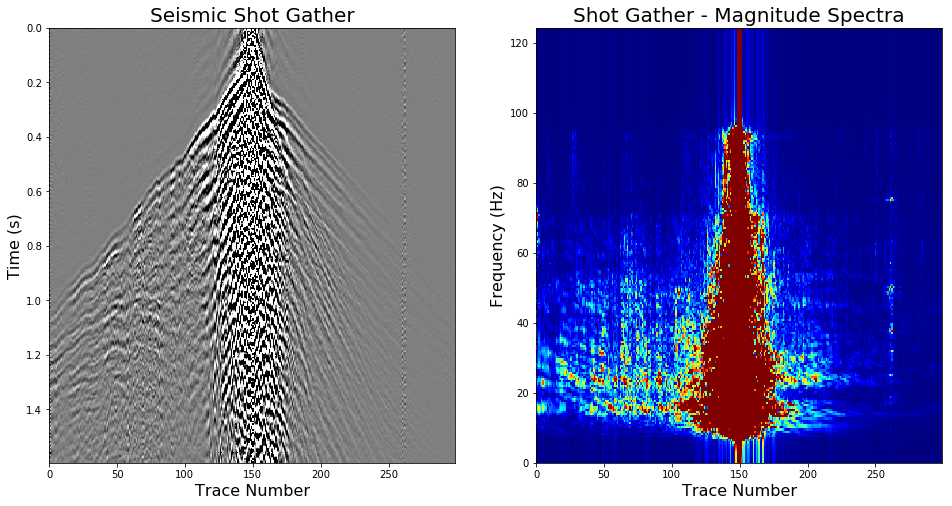

In [14]:
# . . Set figure size
plt.figure(figsize=(16, 8))

# . . Time axis
tline = np.arange(0,nt*dt,dt)

# . . Spatial axis
xline = np.arange(0,nx*dx,dx)

# . . Plot time-domain shot gather
plt.subplot(1,2,1)
plt.pcolor(xline,tline,data2,vmin=-0.00002, vmax=0.00002,cmap='gray')
plt.axis([np.min(xline), np.max(xline), np.max(tline), np.min(tline)])
plt.xlabel('Trace Number',fontsize=16)
plt.ylabel('Time (s)',fontsize=16)
plt.title('Seismic Shot Gather',fontsize=20)

## . . Define the Fourier vector (i.e., omega space)
freqs = np.fft.fftfreq(nt,dt)

## . . Take the FFT in the first axis
Y = np.fft.fft(data2,axis=0)   # fft computing and normalization

plt.subplot(1,2,2)
plt.pcolor(xline,freqs[0:int(nt/2)],abs(Y[0:int(nt/2),:]),vmin=0,vmax=0.0004,cmap='jet')
plt.xlabel('Trace Number',fontsize=16)
plt.ylabel('Frequency (Hz)',fontsize=16)
plt.title('Shot Gather - Magnitude Spectra',fontsize=20)
plt.axis([np.min(xline), np.max(xline), 0, np.max(freqs)])
plt.show()

**Figure 11. Illustration of a seismic shot gather (left panel) and its 1D Fourier Transform over the time axis that displays the Fourier magnitude spectra for each trace (right panel).**

## Pianos and Earthquakes - Redux

At the start of this section we examined a number of different signals.  Having read and digested the comments in the section above, you can now look at these signals Fourier spectra!

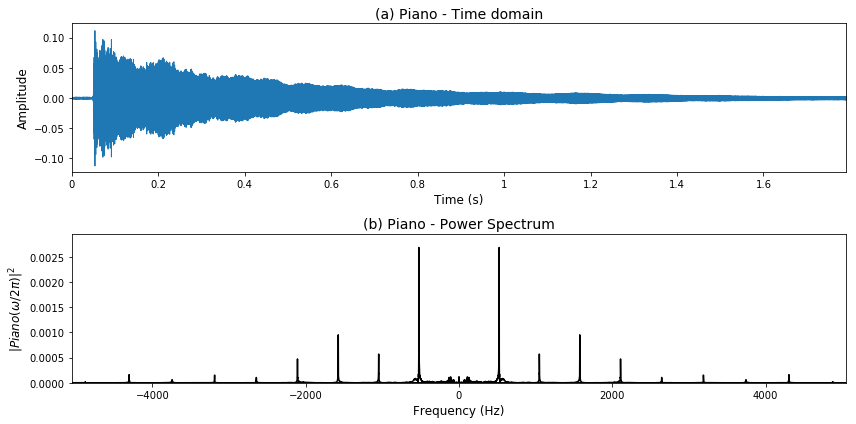

In [21]:
plt.close('all')
plt.figure(figsize=(12, 6))

# . . replot from above
plt.subplot(211)
librosa.display.waveplot(2*piano, sr=srp)
plt.xlabel('Time (s)',fontsize=12)
plt.ylabel('Amplitude',fontsize=12)
plt.title('(a) Piano - Time domain',fontsize=14)

# length of the signal
npiano = len(piano)

# . . Define the Fourier vector
freqP = np.fft.fftfreq(npiano,1./srp)

# . . Take Fourier Transform and normalize by 'n' samples
Fpiano = np.fft.fft(piano)/npiano

# . . Plot the real component of the Fourier Transform
plt.subplot(212)
plt.plot(freqP,abs(Fpiano),'k') 
plt.xlabel('Frequency (Hz)',fontsize=12)
plt.ylabel('$|Piano(\omega/2\pi)|^2$',fontsize=12)
plt.title('(b) Piano - Power Spectrum',fontsize=14)
plt.axis([-5050,5050,0,1.1*max(abs(Fpiano))])

plt.tight_layout() # . . Make it so that the subplots don't overlap
plt.show()

**Figure 12. (a) Time series of a piano playing middle C at 523 Hz. (b) Fourier Power Spectrum of the signal in (a).**  

Let's listen to this time series signal again:

In [22]:
ipd.Audio(piano, rate=srp) 

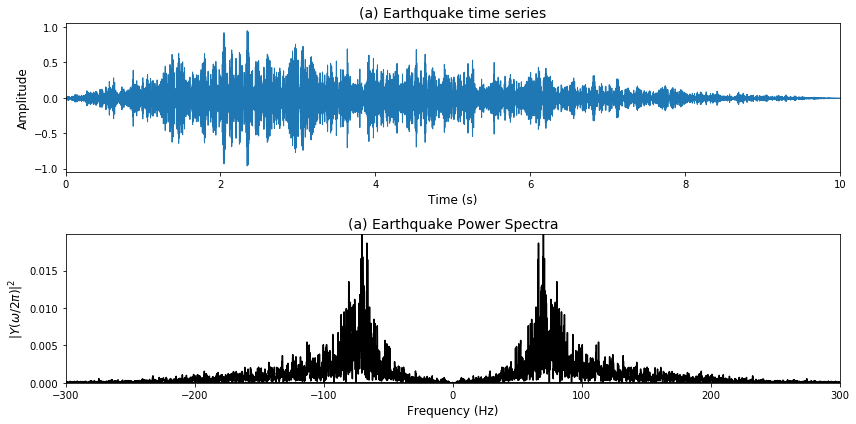

In [23]:
# . . Reload and plot
xx, sr = librosa.load('wav/equake4.wav')

# . . Length of vector
nx = len(xx)

plt.figure(figsize=(12, 6))
plt.subplot(211)
librosa.display.waveplot(xx, sr=sr)
plt.xlabel('Time (s)',fontsize=12)
plt.ylabel('Amplitude',fontsize=12)
plt.title('(a) Earthquake time series',fontsize=14)

# . . Define the Fourier vector based on the length of xx
freqs = np.fft.fftfreq(nx,1./sr)

# . . Take Fourier Transform and normalize 
Y = np.fft.fft(xx)/nx

# . . Plot the real component of the Fourier Transform
plt.subplot(212)
plt.plot(freqs,abs(Y),'k') 
plt.xlabel('Frequency (Hz)',fontsize=12)
plt.ylabel('$|Y(\omega/2\pi)|^2$',fontsize=12)
plt.axis([-300,300,0,max(abs(Y))])
plt.title('(a) Earthquake Power Spectra',fontsize=14)

plt.tight_layout() # . . Make it so that the subplots don't overlap
plt.show()

**Figure 13. (a) Time series of an earthquake. (b) Fourier Power Spectrum of the signal in (a).**  

Let's listen to this time-series signal again:

In [24]:
ipd.Audio(xx, rate=sr) 

## Parting thoughts

It's important to develop a good conceptual understanding of how time-domain signal "look" in the Fourier domain.  This will help you "talk Fourier" to your colleagues (families and friends), and is an essential part of scientist's tool kit who deals with input data.  

Likewise, understanding the properties (including symmetry) of the Fourier Transform is important for many of the items that will come in the following sections.  Of particular importance are functions like the $\delta$, Gaussian, Exponential Decay and Impulse train.  

Finally, I'd recommend downloading a few other WAV files from the interwebs, plotting them up and looking at their spectra.  You can also grab your favorite piece of geophysical data and look at it as well! I guarantee that there will be interesting things in there that you wouldn't have noticed if you were just hanging out in the time domain.

Next step: 2D Fourier Transforms.

## Additional References

1. Bracewell, R.N., 1965, The Fourier Transform and Applications, McGraw-Hill, New York.
2. James, J.F., 2011, A Student's Guide to Fourier Transforms, 3rd ed, Cambridge University Press.
